# Lab 11

In [1]:
library(tidyverse)
library(stringr)
library(modelr)

options(repr.plot.height=4, repr.plot.height=4)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Review/Explore

### Modeling - Setup

The lecture notes have done a thorough job of explaining the setup of a statistical model. But in general when we model data we are trying to predict some output `y`, based on the some inputs, `x`, with some estimated error, epsilon.

$$\underbrace{Y}_{\text{outcome}} = \underbrace{f}_{\text{model function}}(\underbrace{X}_{\text{explainer}}) + 
    \underbrace{\epsilon}_\text{noise}$$

Where f(x) could be any type of model we think fits well with the data (e.g. fitting a line to the data, fitting a parabola to the data, fitting a series of curved lines, etc.) and the 'noise' here refers to the fact that we know our model isn't going to perfectly fit the data.

## Linear Regression: Pokemon Data - Modeling the Capture Rate of Pokemon

In [2]:
pokemon = readRDS("pokemon.rds")
pokemon %>% head

,attack,defense,hp,generation,is_legendary,capture_rate
Bulbasaur,49,49,45,1,0,0.5521758
Ivysaur,62,63,60,1,0,0.6575165
Venusaur,100,123,80,1,0,0.5204006
Charmander,52,43,39,1,0,0.8253708
Charmeleon,64,58,58,1,0,0.5775780
Charizard,104,78,78,1,0,0.8158183


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


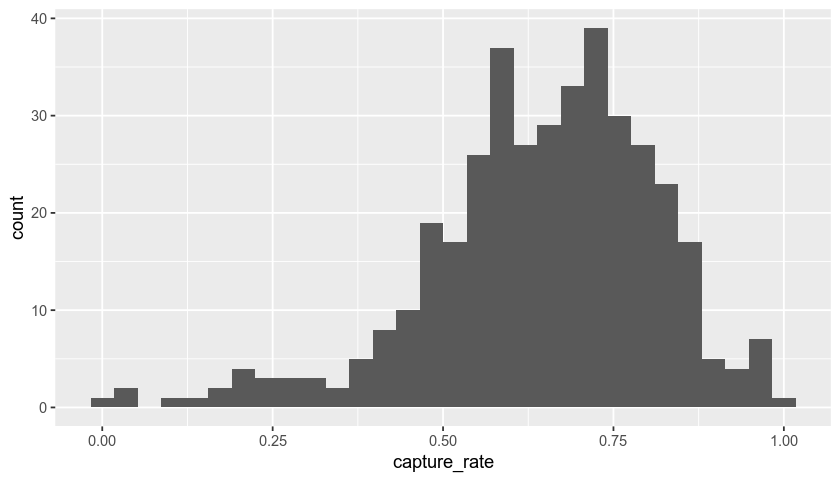

In [3]:
pokemon %>% ggplot(aes(capture_rate)) + geom_histogram()

Here is the initial model, it is additive and linear with respect to all covariates

In [4]:
mod1 = lm(capture_rate ~., data = pokemon)
summary(mod1)


Call:
lm(formula = capture_rate ~ ., data = pokemon)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.311707 -0.051466 -0.002665  0.055174  0.249971 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.8637310  0.0168377  51.298  < 2e-16 ***
attack       -0.0007765  0.0001787  -4.344 1.80e-05 ***
defense      -0.0012903  0.0001668  -7.736 9.35e-14 ***
hp           -0.0006092  0.0001830  -3.329 0.000958 ***
generation2   0.1284794  0.0122619  10.478  < 2e-16 ***
generation3  -0.1492484  0.0111816 -13.348  < 2e-16 ***
is_legendary -0.1646485  0.0224082  -7.348 1.25e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0941 on 379 degrees of freedom
Multiple R-squared:  0.6945,	Adjusted R-squared:  0.6897 
F-statistic: 143.6 on 6 and 379 DF,  p-value: < 2.2e-16


In [5]:
pokemon %>% model_matrix(capture_rate ~.) %>% head

(Intercept),attack,defense,hp,generation2,generation3,is_legendary
1,49,49,45,0,0,0
1,62,63,60,0,0,0
1,100,123,80,0,0,0
1,52,43,39,0,0,0
1,64,58,58,0,0,0
1,104,78,78,0,0,0


### 1 Interaction between two categorical variables

In [6]:
pokemon %>% model_matrix(~is_legendary:generation) %>% unique %>% select(-`(Intercept)`)

is_legendary:generation1,is_legendary:generation2,is_legendary:generation3
0,0,0
1,0,0
0,1,0
0,0,1


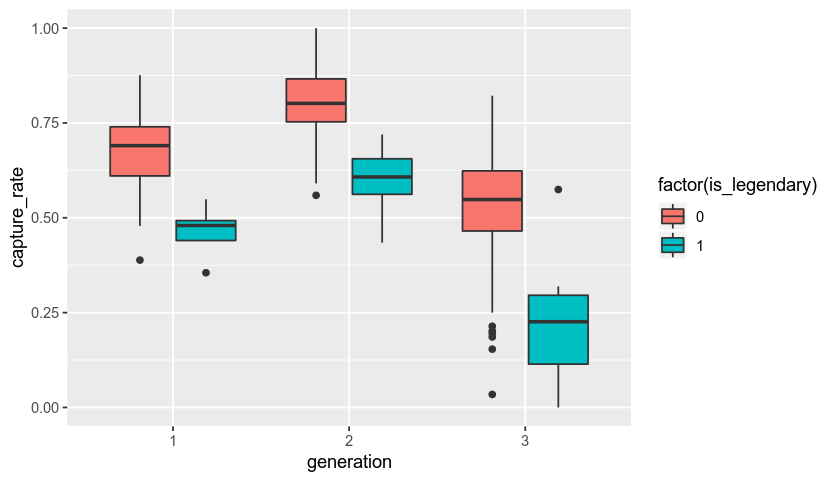

In [7]:
pokemon %>% 
ggplot(aes(y = capture_rate, x = generation, fill = factor(is_legendary))) + 
geom_boxplot()

### 2 Interaction between categorical and numerical variables

In [8]:
pokemon %>% model_matrix(~generation:attack) %>% select(-`(Intercept)`) %>% head

generation1:attack,generation2:attack,generation3:attack
49,0,0
62,0,0
100,0,0
52,0,0
64,0,0
104,0,0


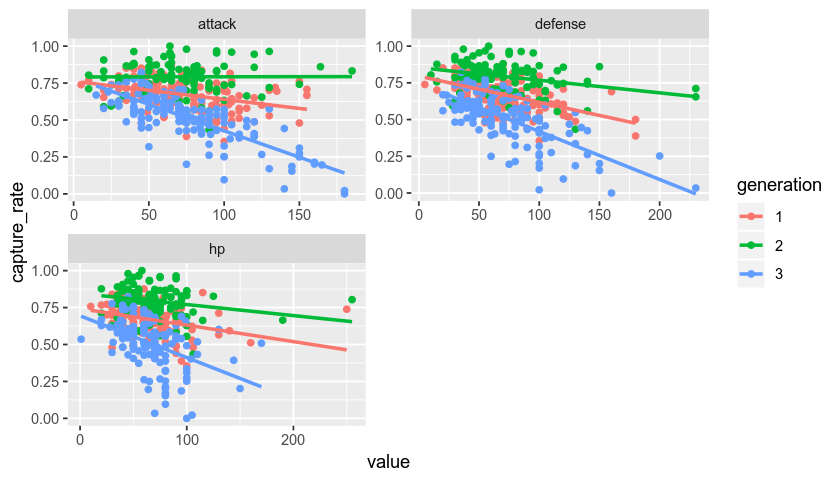

In [9]:
pokemon %>%
  gather(-capture_rate, -generation, -is_legendary, key = "var", value = "value") %>% 
  ggplot(aes(x = value, y = capture_rate, color = generation)) +
    geom_point() + geom_smooth(se=F, method = "lm")  +
    facet_wrap(~var, ncol=2, scale = "free") 

In [10]:
pokemon %>% model_matrix(~is_legendary:attack) %>% select(-`(Intercept)`) %>% head

is_legendary:attack
0
0
0
0
0
0


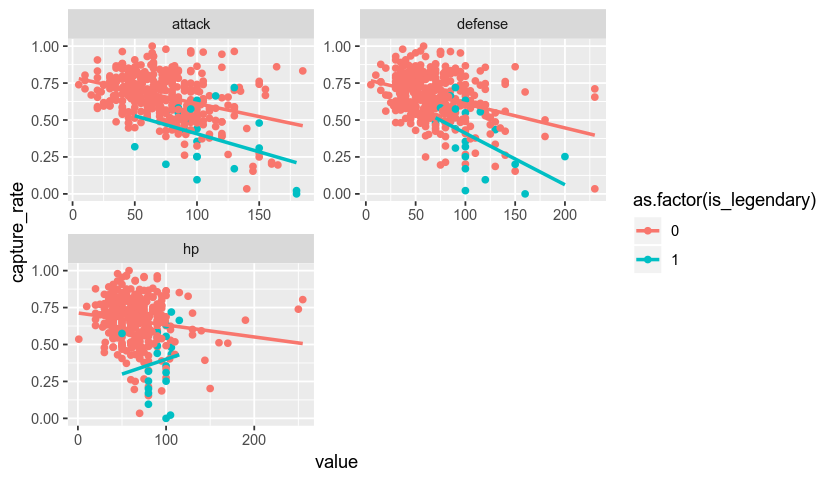

In [11]:
pokemon %>%
  gather(-capture_rate, -generation, -is_legendary, key = "var", value = "value") %>% 
  ggplot(aes(x = value, y = capture_rate, color = as.factor(is_legendary))) +
    geom_point() + geom_smooth(se=F, method = "lm")  +
    facet_wrap(~var, ncol=2, scale = "free") 

### 3 Interaction between two numerical variables

In [12]:
hp_df = pokemon %>% model_matrix(~capture_rate + hp:defense) %>% select(-`(Intercept)`)
hp_df %>% head

capture_rate,hp:defense
0.5521758,2205
0.6575165,3780
0.5204006,9840
0.8253708,1677
0.5775780,3364
0.8158183,6084


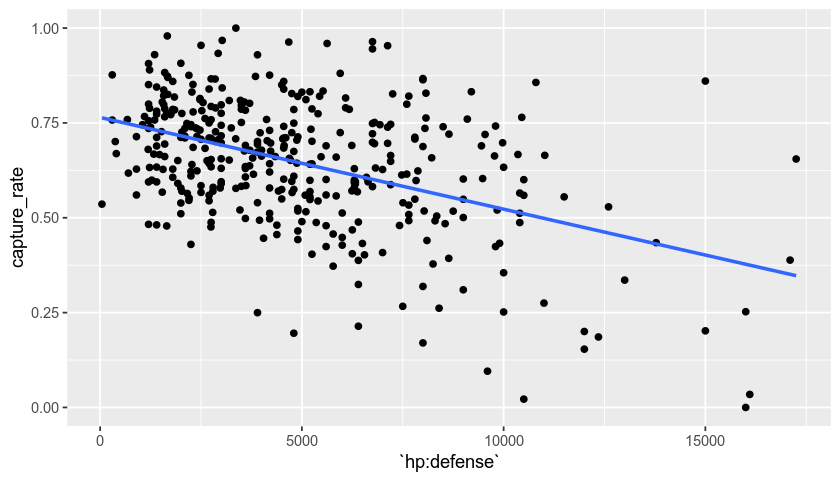

In [13]:
hp_df %>%
ggplot(aes(x = `hp:defense`, y = capture_rate)) +
    geom_point() + geom_smooth(se=F, method = "lm") 

Let's fit another model with some interactions that we explored above.

In [14]:
mod2 = lm(capture_rate ~.+hp*defense+attack:generation+is_legendary:generation, data = pokemon)
summary(mod2)


Call:
lm(formula = capture_rate ~ . + hp * defense + attack:generation + 
    is_legendary:generation, data = pokemon)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.243268 -0.055783  0.000978  0.055328  0.210336 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               7.596e-01  2.499e-02  30.399  < 2e-16 ***
attack                   -3.679e-05  2.403e-04  -0.153    0.878    
defense                  -3.236e-04  2.922e-04  -1.107    0.269    
hp                        3.433e-04  2.536e-04   1.354    0.177    
generation2               1.713e-02  2.625e-02   0.653    0.514    
generation3               1.868e-02  2.417e-02   0.773    0.440    
is_legendary             -1.495e-01  3.716e-02  -4.023 6.95e-05 ***
defense:hp               -1.742e-05  4.184e-06  -4.164 3.88e-05 ***
attack:generation2        1.692e-03  3.415e-04   4.955 1.10e-06 ***
attack:generation3       -2.211e-03  3.000e-04  -7.371 1.10e-12 ***
gen

Are there any significant interactions in above model?

### Selecting between the models
How should we decide which model to use? We can use `gather_residuals` vs `gather_predicitons`:

In [15]:
pokemon_wr = pokemon %>% gather_residuals(mod1, mod2)
pokemon_pred = pokemon %>% gather_predictions(mod1, mod2)
mdl_smmry = inner_join(pokemon_wr, pokemon_pred)
head(mdl_smmry)

Joining, by = c("model", "attack", "defense", "hp", "generation", "is_legendary", "capture_rate")


model,attack,defense,hp,generation,is_legendary,capture_rate,resid,pred
mod1,49,49,45,1,0,0.5521758,-0.18286932,0.7350451
mod1,62,63,60,1,0,0.6575165,-0.04023231,0.6977488
mod1,100,123,80,1,0,0.5204006,-0.05824097,0.5786415
mod1,52,43,39,1,0,0.8253708,0.08125811,0.7441127
mod1,64,58,58,1,0,0.5775780,-0.12628769,0.7038656
mod1,104,78,78,1,0,0.8158183,0.18100170,0.6348166


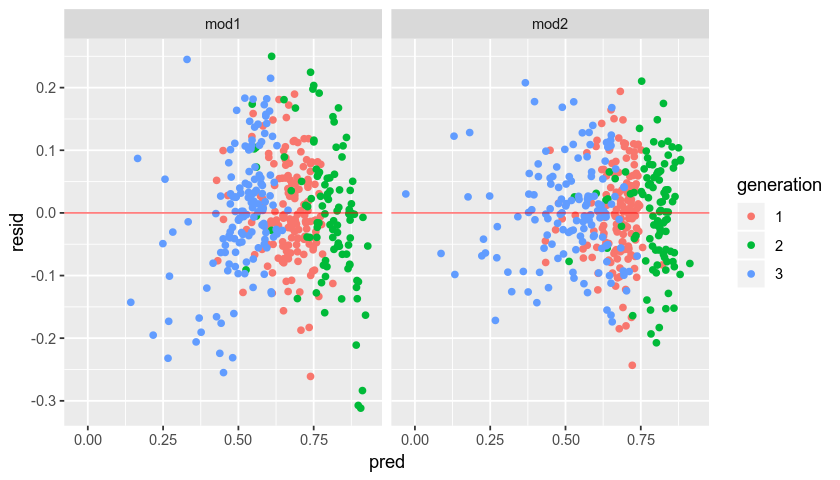

In [16]:
ggplot(mdl_smmry, aes(pred, resid, color = generation)) + 
  geom_point() + geom_hline(yintercept = 0, alpha = 0.5, color = "red") + 
  facet_grid( ~ model)

Which model's residuals look more random to you?

### Another way is comparing $R^2$ values

Here are the alternative representations of $R^2$:

$$R^2 = \frac{\text{Explained variation}}{\text{Total variation}} =1 - \frac{\text{RSS}}{\text{TSS}}= cor(Y, \hat{Y})^2 $$

In [17]:
cor(mod1$fitted.values, pokemon$capture_rate)**2

[1] 0.6945258

In [18]:
summary(mod1)$r.squared

[1] 0.6945258

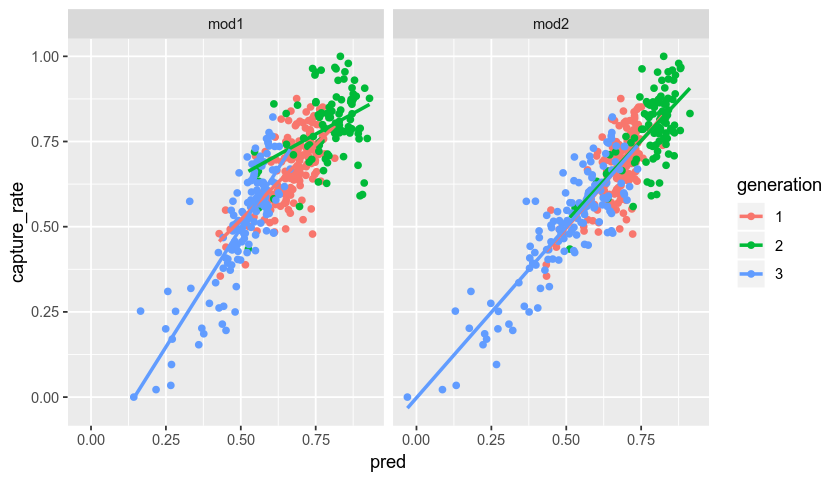

In [19]:
ggplot(mdl_smmry, aes(pred, capture_rate, color = generation)) + 
  geom_point() + geom_smooth(method = "lm", se = F) +
  facet_grid( ~ model)

Which model is the better fit? Why?

# Logistic Regression: Impeachment of Bill Clinton - Prediction of Senators' votes

In [20]:
impeach = readRDS("impeach.rds")
impeach %>% head

Perjury,Conservatism,ClintonVote
0,92,55
1,100,43
1,68,34
0,58,57
1,90,47
1,80,47


Perjury: Vote on Article I, Perjury:  0 = Not Guilty, 1 = Guilty\
Conservatism: Senator's degree of ideological conservativism (0-100)\
ClintonVote: Percent of the vote Clinton received in the 1996 Presidential election in each state

## Problem 1: Plot Conservatism vs ClintonVote condition on Perjury

## Problem 2: By looking at above plot can you come up with a simple rule for perjury vote pattern?

## Problem 3: Now fit a logistic regression model and report the summary. How can we interpret the model coefficient estimates with respect to odds of Perjury = 1?

## Problem 4: What could be the classification rule for logistic regression model? Compare logistic regression model with ad-hoc model in problem 2. Which one performs better? Can you say anything about limitations of Logistic regression?